In [ ]:
# # Required Packages for the Project RUN ONLY ONCE
# %pip install matplotlib
# %pip install nilearn
# %pip install openpyxl
# %pip install Path
# %pip install seaborn
# %pip install nltools
# %pip install scipy
# %pip install scikit-image
# %pip install nibabel

In [6]:
import pandas as pd
import copy
from nilearn import image, masking
from nilearn.image import load_img
import numpy as np
from skimage import filters
import json
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, plot_prob_atlas
import nibabel as nib

In [2]:
icn = pd.read_csv('ADNI_demos.txt')
#icn.info()

for i in range(2404):
  icn.at[i,"fc_dir"] = icn.iloc[i]["fc_dir"].replace("FC","GIGICA")    # Replacing FC with GIGICA

In [3]:
componentFileName = "adni_aa__sub01_component_ica_s1_.nii"
timeCourseFileName = "adni_aa__sub01_timecourses_ica_s1_.nii"

In [4]:
ADs = list()
CNs = list()

for i in range(2404):
    if icn["ResearchGroup"][i] == "AD":
        ADs.append(icn["fc_dir"][i])
    elif icn["ResearchGroup"][i] == "CN":
        CNs.append(icn["fc_dir"][i])

ADsSize = len(ADs)
CNsSize = len(CNs)

In [5]:
componentIndexes = pd.read_csv('NM_icns_info.csv')
#componentIndexes.info()

domainList = componentIndexes["icn_domain"].tolist()
indexList = componentIndexes["icn_index"].tolist()

groupDict = dict()

metric = {
    "voxelCount": 0
}

for i in range(len(domainList)):
    if domainList[i] not in groupDict:
        groupDict[domainList[i]] = dict()
        groupDict[domainList[i]]["index"]=dict()
        groupDict[domainList[i]]["totalVoxelCount"] = 0
        groupDict[domainList[i]]["avgVoxelCount"] = 0
    groupDict[domainList[i]]["index"][indexList[i]-1]=copy.deepcopy(metric)

#groupDict

In [14]:
AD_Threshold = dict()
CN_Threshold = dict()

structure = {
    "group": copy.deepcopy(groupDict),
    "voxelCount": 0,
    "avgVoxelCount": 0
}

for i in range(ADsSize):
    img_name= "image"+str(i+1)
    AD_Threshold[img_name]=copy.deepcopy(structure)
    # AD_Threshold[img_name]["group"] = copy.deepcopy(groupDict)
    # AD_Threshold[img_name]["voxelCount"] = 0
    # AD_Threshold[img_name]["avgCount"] = 0



for i in range(CNsSize):
    img_name= "image"+str(i+1)
    CN_Threshold[img_name]=copy.deepcopy(structure)
    # CN_Threshold[img_name]["group"] = copy.deepcopy(groupDict)
    # CN_Threshold[img_name]["voxelCount"] = 0
    # CN_Threshold[img_name]["avgCount"] = 0

In [16]:
def calculateVoxels(groupName, imgPathsList):
    for index, path in enumerate(imgPathsList):
        currentImage = "image"+str(index+1)
        spacialMapName = path + componentFileName
        spacialMap = load_img(spacialMapName)
        spacialMap_data = spacialMap.get_fdata()
        # spacialMap_mean = np.average(spacialMap_data)
        for networkName in groupName[currentImage]["group"]:   # SC, AD, VIS, ......

            index_items = groupName[currentImage]["group"][networkName]["index"].items()
            network_count = len(index_items)
            
            for key, value in index_items:  # 63: {voxelCount: 0}

                component_image = image.index_img(spacialMap, key)
                value["voxelCount"] = np.count_nonzero(component_image.get_fdata() > 3*np.std(component_image.get_fdata()))
                # print(value["voxelCount"])
                groupName[currentImage]["group"][networkName]["totalVoxelCount"] += value["voxelCount"]
                groupName[currentImage]["voxelCount"] += value["voxelCount"]
            
            groupName[currentImage]["group"][networkName]["avgVoxelCount"]=groupName[currentImage]["group"][networkName]["totalVoxelCount"]/network_count

        groupName[currentImage]["avgVoxelCount"] = groupName[currentImage]["voxelCount"] / 53
        if index == 0:
            break

In [17]:
calculateVoxels(AD_Threshold, ADs)
# calculateVoxels(CN_Threshold, CNs)

In [ ]:
with open('ads.json','w') as data:
      data.write(json.dumps(AD_Threshold))
with open('cns.json','w') as data: 
      data.write(json.dumps(CN_Threshold))

In [12]:
#Calculating Mean and Standard Deviation for all the AD's and CN's
def getVoxelCountForEachImage(subjectObject):
    arr = []
    for i in subjectObject.keys():
        arr.append(subjectObject[i]["voxelCount"])
    avg = np.average(arr)
    standardDeviation = np.std(arr)
    return [avg,standardDeviation]

ADs_voxelCount = getVoxelCountForEachImage(AD_Threshold)
CNs_voxelCount = getVoxelCountForEachImage(CN_Threshold)

print("Average of AD's Voxel Count: ", ADs_voxelCount[0], ", Standard Deviation of AD's voxel Count: ", ADs_voxelCount[1])
print("Average of CN's Voxel Count: ", CNs_voxelCount[0], ", Standard Deviation of CN's voxel Count: ", CNs_voxelCount[1])



Average of AD's Voxel Count:  86365.26760563381 , Standard Deviation of AD's voxel Count:  6263.579345292291
Average of CN's Voxel Count:  86874.73650793651 , Standard Deviation of CN's voxel Count:  7581.582764308085


In [22]:
AD_Threshold["image1"]["group"]['SC']

{'index': {68: {'voxelCount': 3220},
  52: {'voxelCount': 3021},
  97: {'voxelCount': 3223},
  98: {'voxelCount': 2581},
  44: {'voxelCount': 2854}},
 'totalVoxelCount': 14899,
 'avgVoxelCount': 2979.8}

In [ ]:
subject_4D = load_img(ADs[0]+componentFileName)

subject_data = subject_4D.get_fdata()
subject_threshold = 4*np.std(subject_data)
print(subject_threshold)
subject_mask_whole_brain = masking.compute_brain_mask(subject_4D,threshold=subject_threshold, mask_type="whole-brain")
subject_mask_grey_matter = masking.compute_brain_mask(subject_4D, threshold=subject_threshold, mask_type="gm")
subject_mask_white_matter = masking.compute_brain_mask(subject_4D, threshold=subject_threshold, mask_type="wm")

plot_img(subject_mask_whole_brain)
plot_img(subject_mask_grey_matter)
plot_img(subject_mask_white_matter)

# component = image.index_img(subject_4D,69)
# component_threshold = np.std(component.get_fdata())
# component_mask = masking.compute_brain_mask(component,threshold=component_threshold, mask_type="gm")

# plot_img(component_mask)

1.5499378725312716


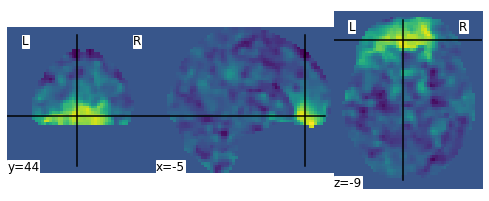

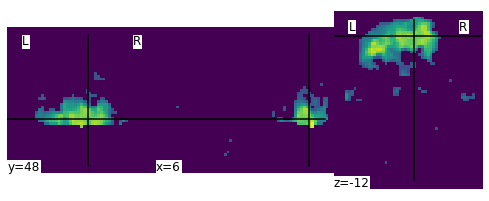

In [27]:
# concat images.
subject_4D = load_img(ADs[0]+componentFileName)
image_list = []

for i in indexList:
    # print(i,end=" ")
    image_list.append(image.index_img(subject_4D,i))

new_image = image.concat_imgs(image_list)
# new_image_data = new_image.get_fdata()
# new_image_threshold = np.std(new_image_data)

# new_image_whole_brain = masking.compute_brain_mask(new_image,threshold=new_image_threshold, mask_type="whole-brain")
# new_image_grey_matter = masking.compute_brain_mask(new_image, threshold=new_image_threshold, mask_type="gm")
# new_image_white_matter = masking.compute_brain_mask(new_image, threshold=new_image_threshold, mask_type="wm")

# plot_img(new_image_whole_brain)
# plot_img(new_image_grey_matter)
# plot_img(new_image_white_matter)

component_image = image.index_img(subject_4D,indexList[3])
plot_img(component_image)

component_data = component_image.get_fdata()
component_threshold = 2.5*np.std(component_image.get_fdata())
print(component_threshold)

l,b,h=component_data.shape
for i in range(l):
    for j in range(b):
        for k in range(h):
            if component_data[i][j][k] <= component_threshold:
                component_data[i][j][k]=0

component_mask = nib.Nifti1Image(component_data, component_image.affine)
plot_img(component_mask)

# print(component_image.shape)

# component_image_data = new_image.get_fdata()
# component_image_threshold = 2*np.std(component_image_data)
# print(component_image_threshold)

# component_image_whole_brain = masking.compute_brain_mask(component_image,threshold=component_image_threshold, mask_type="whole-brain")
# component_image_grey_matter = masking.compute_brain_mask(component_image, threshold=component_image_threshold, mask_type="gm")
# component_image_white_matter = masking.compute_brain_mask(component_image, threshold=component_image_threshold, mask_type="wm")

# plot_img(component_image_whole_brain)
# plot_img(component_image_grey_matter)
# plot_img(component_image_white_matter)

In [12]:
def calculateThresholdAndVoxels(network, componentImage):
    componentImageInArray = componentImage.get_fdata()  ## raw ndarray
    _,threshold = filters.threshold_niblack(componentImageInArray)
    network["threshold"] = threshold
    network["voxelCount"] = np.count_nonzero(componentImage > threshold)

def iterateImages(groupName, imgPathsList):
    for index, path in enumerate(imgPathsList):
        currentImage = "image"+str(index+1)
        spacialMapName = path + componentFileName
        spacialMap = load_img(spacialMapName)
        for networkName in groupName[currentImage]["group"]:   # SC, AD, VIS, ......

            index_items = groupName[currentImage]["group"][networkName]["index"].items()
            network_count = len(index_items)

            for key, value in index_items:  # 63: {threshold: 0, voxelCount: 0}

                component_image = image.index_img(spacialMap, key)
                calculateThresholdAndVoxels(value, component_image)
                groupName[currentImage]["group"][networkName]["totalVoxelCount"]+=value["voxelCount"]
                groupName[currentImage]["voxelCount"] += value["voxelCount"]
            
            groupName[currentImage]["group"][networkName]["avgVoxelCount"]=groupName[currentImage]["group"][networkName]["totalVoxelCount"]/network_count

        groupName[currentImage]["avgVoxelCount"] = groupName[currentImage]["voxelCount"] / 53